## Use the ProcessWordle Module

In [1]:
from importlib import reload
from ProcessWordle import ScrabblePoints, ParseWordle
import censoring

In [3]:
sp = ScrabblePoints(censoring.wordle_answers_input)
sp.read_wordle_answers()
sp.add_total_and_difficulty()

pw = ParseWordle(
    censoring.raw_whatsapp_input, 
    censoring.wordle_output,
    censoring.name_alias
)
pw.create_wordle_df()
pw.process_data_frame()
pw.join_data_frames(sp.words_df)
pw.write_final_df()

## Import Modules for PYMC

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import censoring

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Load Data

In [2]:
# load data
df = pd.read_csv(censoring.wordle_output)

## One more layer of processing

It turns out that if someone does not participate, then they will have a lower score (lower rate of fails) then someone who did particpate.
Thus, the contest should only be around puzzles which have equal contributions. 

In [3]:
# limit to the puzzle in which we last have words
df2 = df[ (df['PuzzleNum'] < 467) & 
         (df['PuzzleNum'] != 421) & 
         (df['Difficulty'] != 'Undefined') & 
         (df['Name'] != 'Player7') & 
         (df['Name'] != 'Player8')
        ].copy()

## This section should move to the App, as a filter
# then I can select all games which have the same 4 players, the same 5 players, etc. 
# and then the model should run on the full data set

# how many players participated, per puzzle? 
puzzle_count_df = df2[['Name','PuzzleNum']].groupby(['PuzzleNum']).agg('count').reset_index()
# list of puzzles which have 6 people, even
list_of_puzzles = puzzle_count_df[ puzzle_count_df['Name'] == 6 ]['PuzzleNum'].tolist()
# over-write previous dataframe 
df2 = df2[ df2['PuzzleNum'].isin(list_of_puzzles)].copy()

## Model 1 - Players, Difficulty are different 'row' values

Things to improve: 
1. Add an error term
2. Try this again with just 'HalfNormals'. 
3. Add some hyper-priors

In [6]:
name_factor, player_names = pd.factorize(df2['Name'], sort=True)
diff_factor, diff_categ = pd.factorize(df2['Difficulty'], sort=True)
puzz_factor, puzz_categ = pd.factorize(df2['PuzzleNum'], sort=True)


with pm.Model(
    coords=coords = {
        "obs": df2.index.values, 
        "Player": player_names,
        "Difficulty": diff_categ
    }
) as BB1:
    # notice there are no 'predictors' in this model, just the response
    
    # using pm.data
    y = pm.MutableData("y", df2['Fails'].to_numpy(), dims="obs")
    
    # Names
    NamesΘα = pm.Gamma("NamesΘα", alpha=3, beta=3, dims="player_names")
    NamesΘβ = pm.Gamma("NamesΘβ", alpha=3, beta=3, dims="player_names")
    
    # Difficulty
    DiffΘα = pm.Gamma("DiffΘα", alpha=3, beta=3, dims="diff_categ")
    DiffΘβ = pm.Gamma("DiffΘβ", alpha=3, beta=3, dims="diff_categ")
    
    # Names/Difficulty interaction
    interθα = pm.Gamma("interθα", alpha=3, beta=3, dims=("player_names", "diff_categ"))
    interθβ = pm.Gamma("interθβ", alpha=3, beta=3, dims=("player_names", "diff_categ"))
    
    # likelihood
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=NamesΘα[name_factor] + DiffΘα[diff_factor] + interθα[name_factor, diff_factor], 
        beta=NamesΘβ[name_factor] + DiffΘβ[diff_factor] + interθβ[name_factor, diff_factor], 
        observed=y,
        dims="obs"
    )

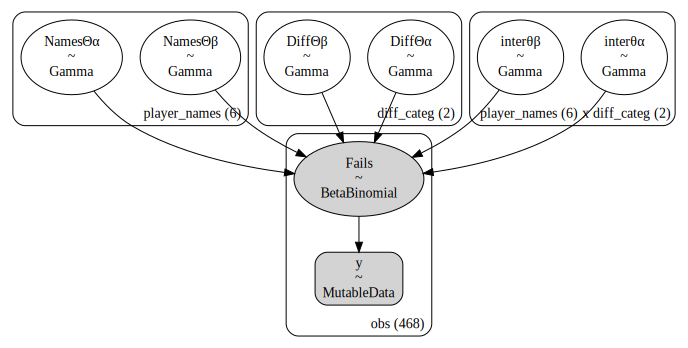

In [7]:
pm.model_to_graphviz(BB1)

In [8]:
with BB1:
    trace1 = pm.sample(
        draws=1000,
        tune=2000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [NamesΘα, NamesΘβ, DiffΘα, DiffΘβ, interθα, interθβ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 268 seconds.


In [9]:
with BB1:
    ppc_data = pm.sample_posterior_predictive(trace1, extend_inferencedata=True)

<AxesSubplot:xlabel='Fails / Fails'>

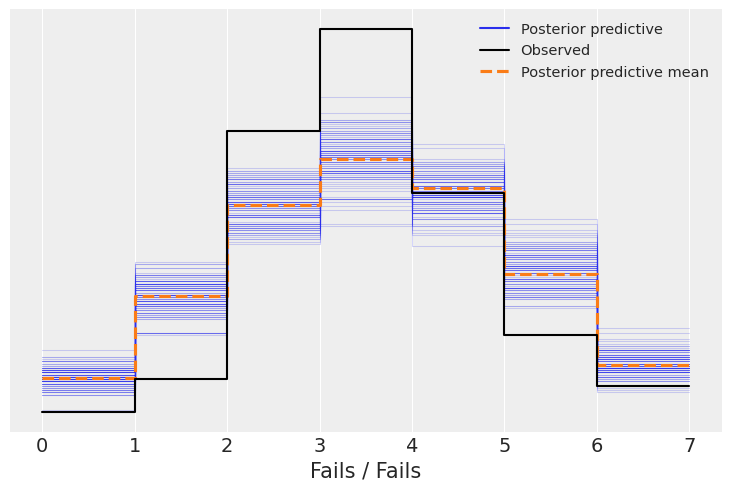

In [10]:
az.plot_ppc(ppc_data, num_pp_samples=100)

### Reshape data to move players/difficulty to columns

In [23]:
df4 = pd.concat(
    [
        pd.concat(
            [
                df2[['PuzzleNum','Fails', 'FinalScore','ScrabblePoints', 'Difficulty']], pd.get_dummies(df2['Name'])
            ], 
            axis=1, 
            ignore_index=True
        ),
        pd.get_dummies(df2['Difficulty'])
    ],
    axis=1,
    ignore_index=True
)

df4 = df4.rename(columns={
    0 : 'PuzzleNum', 
    1 : 'Fails', 
    2 : 'FinalScore',
    3 : 'ScrabblePoints', 
    4 : 'Difficulty', 
    5 : 'Player1', 
    6 : 'Player2', 
    7 : 'Player3', 
    8 : 'Player4', 
    9 : 'Player5', 
    10 : 'Player6',
    11 : 'Easy', 
    12 : 'Hard'
})

df4 = df4.reset_index()

## Model 2
The 'players' are treated as one-hot encoded columns. This allows me to make predicions by using pm.set_data(). But is it worth it? 

Should I be adding a 'puzzle' dimension, here? 
Need to double-check which variables I am pooling / not-pooling. From a conceptual standpoint, each player should be independent, but difficulty should not be independent?

In [11]:
with pm.Model(
    coords={
        "obs": df4.index.values, 
        "Player": ['Player1', 'Player2', 'Player3', 'Player4', 'Player5', 'Player6'],
        "Difficulty":['Easy','Hard']
    }
) as BB2:
    
    # using pm.data
    y = pm.MutableData("y", df4['Fails'].to_numpy())
    x = pm.MutableData("x", df4[['Player1','Player2','Player3','Player4','Player5','Player6','Easy','Hard']].to_numpy())
    
    # Names - Hyper Priors
    HPNamesασ = pm.Normal("HPNamesασ", mu=3, sigma=1)
    HPNamesβσ = pm.Normal("HPNamesβσ", mu=3, sigma=1)
    
    # Difficulty - Hyper Priors  
    HPDiffασ = pm.Normal("HPDiffασ", mu=3, sigma=1)
    HPDiffβσ = pm.Normal("HPDiffβσ", mu=3, sigma=1)
    
    # Names
    Namesα = pm.HalfNormal("Namesα", sigma=HPNamesασ, dims="Player")
    Namesβ = pm.HalfNormal("Namesβ", sigma=HPNamesβσ, dims="Player")

    # Difficulty
    Diffα = pm.HalfNormal("Diffα", sigma=HPDiffασ, dims="Difficulty")
    Diffβ = pm.HalfNormal("Diffβ", sigma=HPDiffβσ, dims="Difficulty")

    # Error
    ϵα = pm.HalfNormal("ϵα", sigma=1)
    ϵβ = pm.HalfNormal("ϵβ", sigma=1)
    
    # likelihood
    θα = pm.Deterministic("θα", pm.math.dot(x[:,0:6], Namesα) + pm.math.dot(x[:, 6:], Diffα) + ϵα)
    θβ = pm.Deterministic("θβ", pm.math.dot(x[:,0:6], Namesβ) + pm.math.dot(x[:, 6:], Diffβ) + ϵβ)

    # response
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=θα, 
        beta=θβ, 
        observed=y
    )

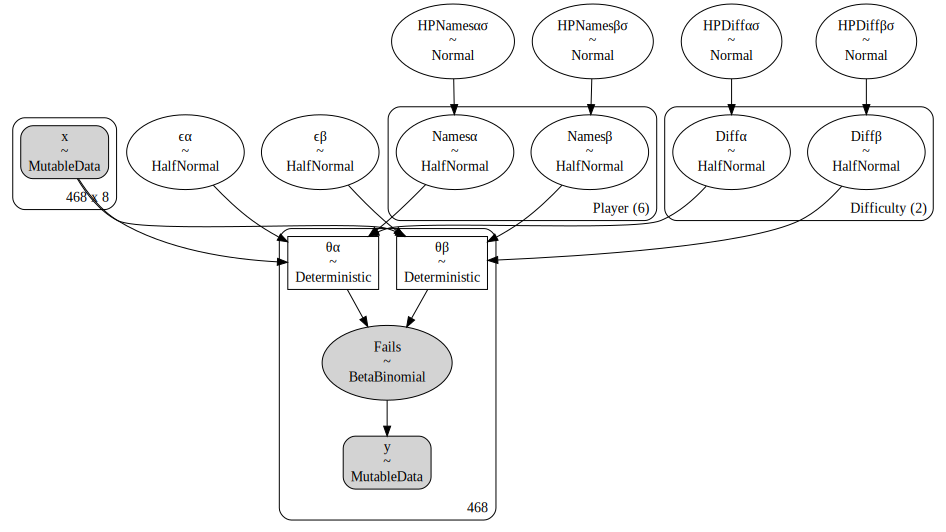

In [12]:
pm.model_to_graphviz(BB2)

In [13]:
with BB2:
    trace2 = pm.sample(
        draws=1000,
        tune=2000,
        # start={
        #     'Namesβ': np.array([1., 1., 1., 1., 1., 1.]), 
        #     'Namesα': np.array([1., 1., 1., 1., 1., 1.]), 
        # }, 
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [HPNamesασ, HPNamesβσ, HPDiffασ, HPDiffβσ, Namesα, Namesβ, Diffα, Diffβ, ϵα, ϵβ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 270 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## Display Summary
The standard deviations of these estimates are enormous! Should the 'names' variables be something else, like a normal or something? 

In [16]:
az.summary(trace2, var_names=["HPNamesασ","HPNamesβσ","HPDiffβσ", "HPDiffασ", "Namesα", "Namesβ", "Diffα", "Diffβ", "ϵα", "ϵβ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
HPNamesασ,3.466,0.907,1.814,5.209,0.020,0.014,2134.0,2585.0,1.0
HPNamesβσ,3.682,0.897,2.025,5.402,0.021,0.015,1900.0,2175.0,1.0
HPDiffβσ,4.079,0.810,2.556,5.573,0.016,0.011,2560.0,2484.0,1.0
HPDiffασ,4.421,0.784,3.054,5.975,0.015,0.011,2746.0,2726.0,1.0
Namesα[Player1],3.235,2.020,0.033,6.780,0.044,0.031,1780.0,1688.0,1.0
Namesα[Player2],3.170,2.066,0.019,6.653,0.045,0.032,1807.0,1591.0,1.0
Namesα[Player3],2.638,1.833,0.001,5.836,0.041,0.029,1719.0,1630.0,1.0
Namesα[Player4],3.184,2.041,0.000,6.730,0.046,0.033,1411.0,1033.0,1.0
Namesα[Player5],4.527,2.527,0.039,8.914,0.059,0.042,1471.0,1053.0,1.0
Namesα[Player6],3.156,2.097,0.010,6.897,0.048,0.034,1556.0,1545.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

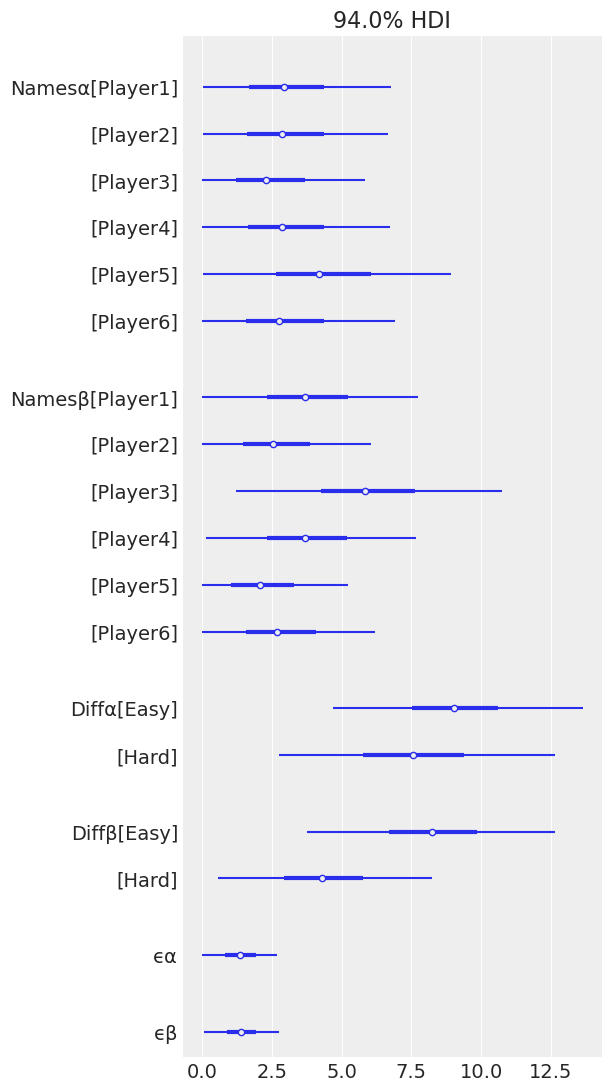

In [18]:
# az.plot_forest(trace2, var_names=["HPNamesασ","HPNamesβσ","HPDiffβσ", "HPDiffασ"], combined=True)
az.plot_forest(trace2, var_names=["Namesα", "Namesβ", "Diffα", "Diffβ", "ϵα", "ϵβ"], combined=True)

## Posterior Predictive

Needs work, but at least I have a solid model to iterate on

In [19]:
with BB2:
    ppc_data_trace2 = pm.sample_posterior_predictive(trace2, extend_inferencedata=True)

<AxesSubplot:xlabel='Fails / Fails'>

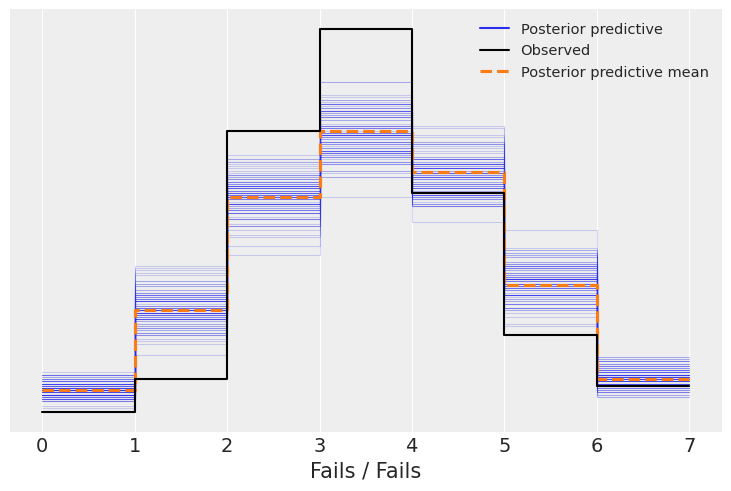

In [20]:
az.plot_ppc(ppc_data_trace2, num_pp_samples=100)

### Permute with set data

In [42]:
test = pd.DataFrame({
    'Players': ['Player1', 'Player2', 'Player3', 'Player4', 'Player5', 'Player6', 'Player1', 'Player2', 'Player3', 'Player4', 'Player5', 'Player6'],
    'Difficulty': ['Easy','Easy', 'Easy','Easy','Easy','Easy','Hard','Hard','Hard','Hard','Hard','Hard']
})

test = pd.get_dummies(test)

test = test.rename(columns={
    1 : 'Player1', 
    2 : 'Player2', 
    3 : 'Player3', 
    4 : 'Player4', 
    5 : 'Player5', 
    6 : 'Player6',
    7 : 'Easy', 
    8 : 'Hard'
})

In [34]:
with BB2:
    pm.set_data({'x': test.to_numpy()})
    y_test = pm.sample_posterior_predictive(trace2)
    
test['prediction'] = y_test.posterior_predictive['Fails'].mean(('chain', 'draw')).to_numpy()

In [41]:
test

,Players_Player1,Players_Player2,Players_Player3,Players_Player4,Players_Player5,Players_Player6,Difficulty_Easy,Difficulty_Hard,prediction
0,1,0,0,0,0,0,1,0,2.99025
1,0,1,0,0,0,0,1,0,3.12775
2,0,0,1,0,0,0,1,0,2.70500
3,0,0,0,1,0,0,1,0,2.99325
4,0,0,0,0,1,0,1,0,3.31675
5,0,0,0,0,0,1,1,0,3.09325
6,1,0,0,0,0,0,0,1,3.35050
7,0,1,0,0,0,0,0,1,3.49375
8,0,0,1,0,0,0,0,1,3.01125
9,0,0,0,1,0,0,0,1,3.37300


## Compare
'p_waic' refers to the effective number of parameters; elpd_waic refers to the 'expected log pointwise predictive density'.

In [ ]:
# az.compare({'BB1': trace1, 'BB2': trace2}, 'waic')